In [9]:
import numpy as np
from hello.pid.lvpid import PIDController
from hello.pid.delay import seconds, minutes, hours, days, m2s, s2m, h2s, DelayBuffer, DelaySink
from hello.pid.gas_process import HeadspaceProcess, GasController
from hello.pid.do_simulation.doprocess import DOProcess, AIR_CNO

from hello.pid.do_simulation.options import SimOps, SimConfig
from hello.pid.picker import mk_picker
from hello.pid.do_simulation.sim_window import PIDSimFrame
from hello.pid.ui import TkQuitHack
from hello.pid.do_simulation.do_sim import do_sim_coroutine, do_sim
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

### Copy this template to ensure all sim options are set correctly

In [11]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 10
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 1
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = 5
ops.n2_pid.i = 5
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 1
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = 1
ops.mfcs.o2_max = 10
ops.mfcs.n2_max = 10
ops.mfcs.air_max = 10

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 10000
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 90
ops.set_point = 40
ops.set_point_deadband = 1
ops.k_mult = 1.1
ops.k = DOProcess.default_k
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 1.0
ops.reactor_size = 80
ops.volume = 55
ops.time_unit = hours
ops.max_iters = 3 * days

# Maximum value of c that O2 controller can sustain for a given k
ops.k*ops.k_mult*(100/20.95)*100

68.57279236276851

In [12]:
cfg = SimConfig()
cfg.simops = ops
def run3():
    global root, f
    cfg.simops.o2_pid.p = 7
    cfg.simops.o2_pid.i = 50
    cfg.simops.o2_pid.amax = 100
    cfg.simops.o2_pid.deadband = 0
    cfg.simops.o2_pid.beta = 0
    cfg.simops.o2_pid.man_request = 10

    cfg.simops.n2_pid.p = -2
    cfg.simops.n2_pid.i = 60
    cfg.simops.n2_pid.amax = 90
    cfg.simops.n2_pid.deadband = 0
    cfg.simops.n2_pid.beta = 0
    cfg.simops.n2_pid.man_request = 10
    cfg.simops.delay=0*minutes

    cfg.update_interval = 50
    cfg.time_factor = 200

    cfg.simops.initial_pv = 100
    cfg.simops.set_point = 100

    cfg.xwindow_hrs = 10

    root = TkQuitHack()
    root.wm_title("DO Simulation")
    #root.geometry("%dx%d"%(600, 800))
    f = PIDSimFrame(root, cfg)
    f.pack()
    root.mainloop()

In [13]:
# O2 needs an extra padding space because the negative sign
# for N2 pgain doesn't count, i guesss
def fmt_float(f):
    if not f:
        return "0"
    f = str(f)
    if "." not in f:
        return f
    else:
        f = f.strip("0")
        if f[-1] == ".":
            f = f[:-1]
        if f[0] == ".":
            f = "0" + f
    return f
def get_text(ops):

    text = \
"""
O2: P=%3d  I=%5d  Initial PV: %3d  k: %.4f/hr (%sx Est.)
N2: P=%3d  I=%4d  Set Point:  %3d  c: %s%%/hr

 """ % (ops.o2_pid.p, ops.o2_pid.i,ops.initial_pv, ops.k*ops.k_mult, fmt_float(ops.k_mult),
        ops.n2_pid.p, ops.n2_pid.i, ops.set_point, fmt_float(ops.c))
    text = text.strip()
    return text

In [14]:
def run(ops):
    global data, data2, text, data3
    data, data2, data3 = do_sim(ops)
    text = get_text(ops)
    plot(ops)
    
def run2(ops):
    global data, data2, text, data3
    data, data2, data3 = do_sim(ops)
    text = get_text(ops)
    plot1(ops)
    
def run_int(ops):
    global data, data2, text, data3
    data, data2, data3 = do_sim(ops)
    text = get_text(ops)
    plot_int(ops)

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib

def plot_int(ops):    
    print("Parsing Data")
    global x, pv, cs, co2_req, n2_req, o2_req, air_req, co2a, n2a, o2a, uk, up, ui, ud
    x, pv, cs, co2_req, n2_req, o2_req, air_req, o2a = list(zip(*data))
    uk, up, ui, ud = list(zip(*data2))
    print("Closing Plot")
    plt.close()
    print("Plotting Data")

    step = 100
    xs = x[::step]
    xs = np.array(xs) / ops.plots.xscale_factor * ops.time_unit
    fig = plt.figure()
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    pvs = np.array(pv[::step])
    ax1.plot(xs, pvs, "blue", ls="-", label="PV")
    ax1.axhline(y=ops.set_point, ls="--", color="black")

    ax2.plot(xs, co2_req[::step], "purple", ls="-", label="CO2")
    ax2.plot(xs, n2_req[::step], "red", ls="-", label="N2")
    ax2.plot(xs, o2_req[::step], "green", ls="-", label="O2")
    ax2.plot(xs, air_req[::step], "cyan", ls="-", label="Air")
    fm1 = FuncFormatter(lambda y, _: "%.2f%%"%y)
    fm2 = FuncFormatter(lambda y, _: "%.2f%%"%(y*100))

    ax3.plot(xs, pvs, "blue", ls="-", label="O2 sln")
    ax3.plot(xs, np.array(o2a[::step])*100/.2095, "red", ls="-", label="O2 hs")

    ax1.yaxis.set_major_formatter(fm1)
    ax2.yaxis.set_major_formatter(fm2)
    ax2.set_ylim((0, 1.1))
    
    m, ma = ax1.get_ylim()
    if np.min(pvs) - 1 < m:
        m -= 1
    if np.max(pvs) + 1 > ma:
        ma += 1
    ax1.set_ylim((m, ma))
    #ax1.set_ylim((sp-5, sp+5))


    for a in ax1, ax2, ax3: 
        b = a.get_position()
        a.set_position([b.x0, b.y0, b.width*0.9, b.height])
        a.legend(bbox_to_anchor=(0.99, 1.06), loc="upper left")
        a.grid()
        if ops.plots.xscale == 'man':
            a.set_xlim((ops.plots.xmin, ops.plots.xmax))
    
    fig.text(0.15, 0.95, get_text(ops), transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
    
    wm=plt.get_current_fig_manager()
    wm.window.attributes('-topmost', 1)
    wm.window.attributes('-topmost', 0)
    # h = wm.window.winfo_height()
    # w = wm.window.winfo_width()
    wm.window.geometry("%sx%s+%s+%s"%(700,720,50, 20))

Using matplotlib backend: TkAgg


In [16]:
def test3(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_ = list(zip(*d1))
    return x,pv, n2, o2

In [17]:
k_80L = 0.1306
k_15L = 0.19314
k_3L  = 0.24286

# 15L DO Simulations for Results Report

In [21]:
ops = SimOps()
ops.o2_pid.p = 7
ops.o2_pid.i = 50
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -6
ops.n2_pid.i = 90
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = 0.5
ops.mfcs.n2_max = 2
ops.mfcs.air_max = 2

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 20*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.00, 0, 0)
ops.initial_pv = 100
ops.set_point = 50
ops.set_point_deadband = 1
ops.k_mult = 1.0
ops.k = k_15L
ops.c = 0
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 1.0
ops.reactor_size = 15
ops.reactor_volume = 11.5
ops.time_unit = hours
ops.max_iters = 3 * days

### Graph generation for Results report for 100% to 150% ramp

In [22]:
ops.set_point = 150
ops.mfcs.o2_max = 2
x, pv, n2, o2 = test3(ops)
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
f = FuncFormatter(lambda y, _: "%.1f%%"%(y*100))
l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax2.yaxis.set_major_formatter(f)
ax.plot(x,pv, "blue", ls="-", label="PV")
ax2.plot(x,o2, "green", ls="-", label="O2 Flow")
ax2.plot(x,n2, "red", ls="-", label="N2 Flow")
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax2.yaxis.set_label_text("Gas Flow Request (%)")
ax.grid()
ax.set_ylim(100, 160)
ax2.set_ylim(0, .80)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h1.extend(h2)
l1.extend(l2)
ax.legend(h1, l1, loc="center", ncol=3, bbox_to_anchor=(0.5, -.15))
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax2.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))

### Graph generation for Results report for 100% to 50% ramp

In [23]:
from matplotlib.ticker import MultipleLocator
ops.k_mult = 0.9
ops.set_point = 50

ops.n2_pid.p = -3
x, pv, n2, o2 = test3(ops)
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
f = FuncFormatter(lambda y, _: "%.1f%%"%(y*100))
ax2.yaxis.set_major_formatter(f)
l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax.plot(x,pv, "blue", ls="-", label="PV")
ax2.plot(x,o2, "green", ls="-", label="O2 Flow")
ax2.plot(x,n2, "red", ls="-", label="N2 Flow")
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax2.yaxis.set_label_text("Gas Flow Request (%)")
ax.grid()
ax.set_ylim(40, 110)
ax2.set_ylim(0, 1.00)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h1.extend(h2)
l1.extend(l2)
ax.legend(h1, l1, loc="center", ncol=3, bbox_to_anchor=(0.5, -.15))
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width*0.95,b.height*0.9))
ax2.set_position((b.x0, b.y0+0.05, b.width*0.95,b.height*0.9))

### Comparison of effect of Main Gas on controller performance

In [26]:
ops.set_point = 150
plt.close()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax.grid()
ax.set_ylim(100, 160)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
for mg in (0.1, 0.5, 1.0, 2.0):
    ops.main_gas = mg
    x, pv, n2, o2 = test3(ops)
    ax.plot(x,pv, label="%.1f LPM"%mg)
    
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, -.15))

In [25]:
ops.set_point = 150

plt.close()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax.grid()
ax.set_ylim(100, 160)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ops.reactor_volume = 11
ops.main_gas = 2
x, pv, n2, o2 = test3(ops)
ax.plot(x,pv, label="2 LPM")
    
ops.reactor_volume = 13
ops.main_gas = mg = 1
x, pv, n2, o2 = test3(ops)
ax.plot(x,pv, label="1 LPM")
    
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, -.15))

# 80L Simulations for Results Report

In [9]:
ops = SimOps()
ops.o2_pid.p = 3
ops.o2_pid.i = 70
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -3
ops.n2_pid.i = 70
ops.n2_pid.d = 0
ops.n2_pid.amax = 100
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = 1
ops.mfcs.o2_max = 2
ops.mfcs.n2_max = 10
ops.mfcs.air_max = 10

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 20*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.00, 0, 0)
ops.initial_pv = 100
ops.set_point = 150
ops.set_point_deadband = 1
ops.k_mult = 1.1
ops.k = k_80L
ops.c = 0
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 2.0
ops.reactor_size = 80
ops.reactor_volume = 57
ops.time_unit = hours
ops.max_iters = 3 * days

In [10]:
ops.set_point = 50
x, pv, n2, o2 = test3(ops)

In [11]:
# Plot configuration
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax2.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))


In [12]:
ax.clear()
ax2.clear()
f = FuncFormatter(lambda y, _: "%.1f%%"%(y*100))
l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax2.yaxis.set_major_formatter(f)
ax.plot(x,pv, "blue", ls="-", label="PV")
ax2.plot(x,o2, "green", ls="-", label="O2 Flow")
ax2.plot(x,n2, "red", ls="-", label="N2 Flow")
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax2.yaxis.set_label_text("Gas Flow Request (%)")
ax.grid()
# ax.set_ylim(100, 160)
# ax2.set_ylim(0, .80)
ax.set_ylim(40, 110)
ax2.set_ylim(0, 1.10)
for t in fig.texts: t.remove()
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h1.extend(h2)
l1.extend(l2)
ax.legend(h1, l1, loc="center", ncol=3, bbox_to_anchor=(0.5, -.15))
ax.set_position((b.x0, b.y0+0.05, b.width*0.95,b.height*0.9))
ax2.set_position((b.x0, b.y0+0.05, b.width*0.95,b.height*0.9))

In [ ]:
ax.set_ylim(145, 155)

# 3L DO Tuning and Characterization

In [3]:
from officelib.xllib import *
from officelib.const import xlconst as xlc
import itertools
from pysrc.snippets import smooth1
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

def clear_data():
    xldata.clear()
    loaded_data.clear()

path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\PID Tuning\\DO\\raw data\\'
xldata = []
def add_data(fn, pvr, o2r, n2r):
    fn = path + fn
    xldata.append((fn, pvr, o2r, n2r))

In [4]:
_ref_cache = {}
def clear_cache():
    _ref_cache.clear()
    
def _load(cr, r):
    x,y = [np.array(v) for v in list(zip(*cr(r).Value))]
    x2, y2 = smooth1(np.rint(x*3600).astype(int), y.astype(float))
    x3 = np.array(list(map(float, x2))) / 3600
    y3 = np.array(list(map(float, y2)))
    return x3, y3    

def load_data(data=None):
    if data is None:
        data = xldata
    global loaded_data, _ref_cache
    loaded_data = []
    xl = None
    for fn, pvr, o2r, n2r in data:
        cache_key = (fn, pvr, o2r, n2r)
        if cache_key in _ref_cache:
            (pvx, pvy), (o2x, o2y), (n2x, n2y) = _ref_cache[cache_key]
        else:
            if xl is None:
                xl = Excel()
            with screen_lock(xl):
                wb = xl.Workbooks.Open(fn)
                ws = wb.Worksheets("Data2")
                cr = ws.Cells.Range
                try:
                    pvx, pvy = _load(cr, pvr)
                    o2x, o2y = _load(cr, o2r)
                    n2x, n2y = _load(cr, n2r)
                except:
                    print(pvr, o2r, n2r)
                    raise
                wb.Close()
                _ref_cache[cache_key] = (pvx, pvy), (o2x, o2y), (n2x, n2y)
        
        loaded_data.append(((pvx, pvy), (o2x, o2y), (n2x, n2y)))
    if xl is not None:
        xl.Quit()
        
def np_unpack(l):
    return [np.array(data) for data in list(zip(*l))]

### 3L Basic Options

In [20]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 40
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -5
ops.n2_pid.i = 40
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = .5
ops.mfcs.n2_max = .5
ops.mfcs.air_max = .5

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 12*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 100
ops.set_point = 50
ops.set_point_deadband = 1
ops.k_mult = 1
ops.k = k_3L
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 0.2
ops.reactor_size = 3
ops.volume = 2.5
ops.time_unit = hours
ops.max_iters = 3 * days

In [21]:
ax_list1 = []
fig = None

def axes():
    return ax_list1

def setup1(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    global ax_list1
    
    if not plt.get_fignums() or new or not fig:
        fig = plt.figure()
        ax1 = fig.add_subplot(3,1,1)
        ax2 = fig.add_subplot(3,1,2)
        ax3 = fig.add_subplot(3,1,3)
        for a in ax1, ax2, ax3:
            b = a.get_position()
            a.set_position([b.x0, b.y0, b.width*0.9, b.height])
            a.grid()
        ax_list1 = [ax1, ax2, ax3]
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__
    
def test1(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_, o2a = np_unpack(d1)
    return x,pv, n2, o2, o2a*100/0.21

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)

def plot1(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    _p1(ax3, x, pv, "blue", "pv", "DO (%)")
    _p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        a.legend(bbox_to_anchor=(0.99, 1.06), loc="upper left")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish1():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    
def run1(ops):
    x, pv, n2, o2, o2a = test1(ops)
    plot1(x, pv, n2, o2, o2a)
    finish1()

### 3L Tuning (Final!)

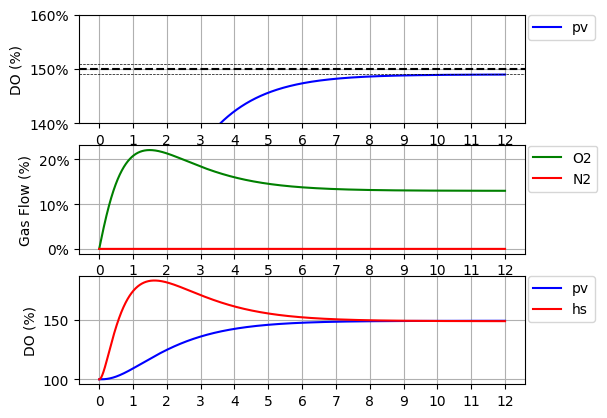

In [25]:
setup1()
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100

ops.o2_pid.p = 1.5
ops.o2_pid.i = 120

ops.n2_pid.p = -5
ops.n2_pid.i = 50
ops.k_mult = 1
run1(ops)
ax1.set_ylim(140, 160)
fig

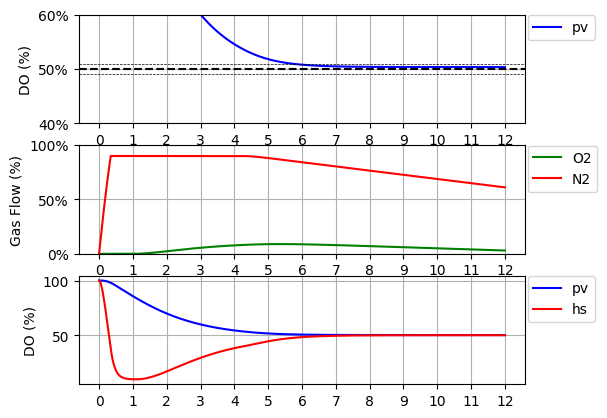

In [26]:
setup1()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

ops.o2_pid.p = 1.5
ops.o2_pid.i = 120

ops.n2_pid.p = -5
ops.n2_pid.i = 50
ops.k_mult = 1
run1(ops)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)
fig

In [27]:
setup1(True)
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100

ops.o2_pid.p = 7
ops.o2_pid.i = 50

ops.n2_pid.p = -5
ops.n2_pid.i = 50
ops.k_mult = 1
run1(ops)
ax1.set_ylim(140, 160)

(140, 160)

In [28]:
setup1()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

ops.o2_pid.p = 7
ops.o2_pid.i = 50

ops.n2_pid.p = -5
ops.n2_pid.i = 50
ops.k_mult = 1
run1(ops)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)

TclError: this isn't a Tk application

### 3L Graphs for Report

In [22]:
ax_list2 = []
fig = None

def axes():
    return ax_list2

def setup2(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    global ax_list2
    
    if not plt.get_fignums() or new or not fig:
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        #ax2 = fig.add_subplot(2,1,2)
        ax2 = ax1.twinx()
        ax_list2 = [ax1, ax2]
        for a in axes():
            b = a.get_position()
            a.set_position([b.x0, b.y0+.1, b.width*.95, b.height*.85])
            a.grid()
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__
    
def test2(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_, o2a = np_unpack(d1)
    return x,pv, n2, o2, o2a*100/0.21

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)

def plot2(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    #_p1(ax3, x, pv, "blue", "pv", "DO (%)")
    #_p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish2():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    
def run2(ops):
    x, pv, n2, o2, o2a = test2(ops)
    plot2(x, pv, n2, o2, o2a)
    finish2()

#### Export figures, aggressive

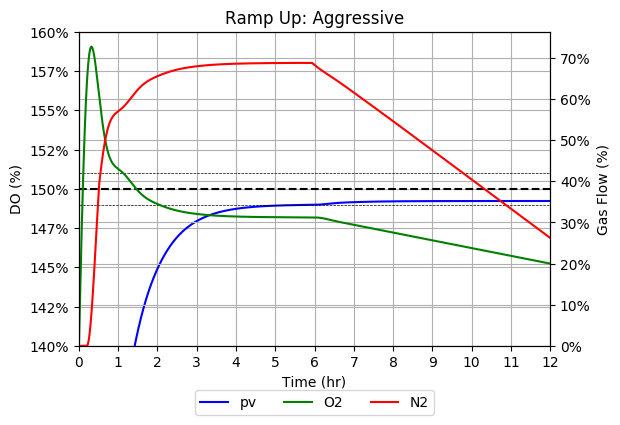

In [30]:
setup2()
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100
ops.end = 12*hours

# Aggressive
ops.o2_pid.p = 7
ops.o2_pid.i = 50
ops.n2_pid.p = -6
ops.n2_pid.i = 90

# Slower
# ops.o2_pid.p = 1.5
# ops.o2_pid.i = 120
# ops.n2_pid.p = -5
# ops.n2_pid.i = 50

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(140, 160)
a,b = ax2.set_ylim()
ax2.set_ylim(0, b)
ax1.set_title("Ramp Up: Aggressive")
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
#fig.savefig(path+"\\3L ramp up aggressive 170719.png")

fig

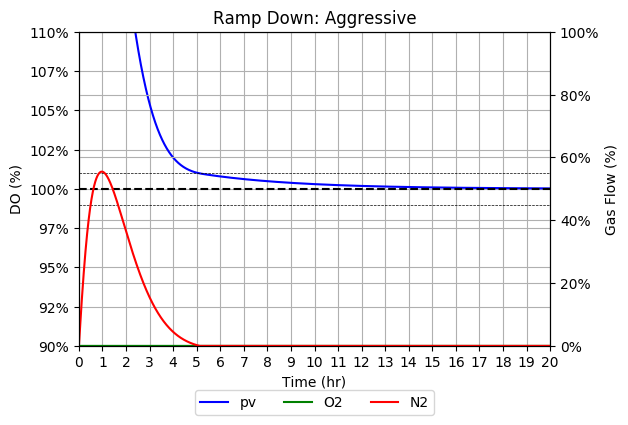

In [26]:
setup2()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

# Aggressive
ops.o2_pid.p = 7
ops.o2_pid.i = 50
ops.n2_pid.p = -6
ops.n2_pid.i = 90

# Slower
# ops.o2_pid.p = 1.5
# ops.o2_pid.i = 120
# ops.n2_pid.p = -5
# ops.n2_pid.i = 50

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)
ax1.set_title("Ramp Down: Aggressive")

path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\3L ramp down aggressive 170719.png")
fig

#### Export figures, gradual

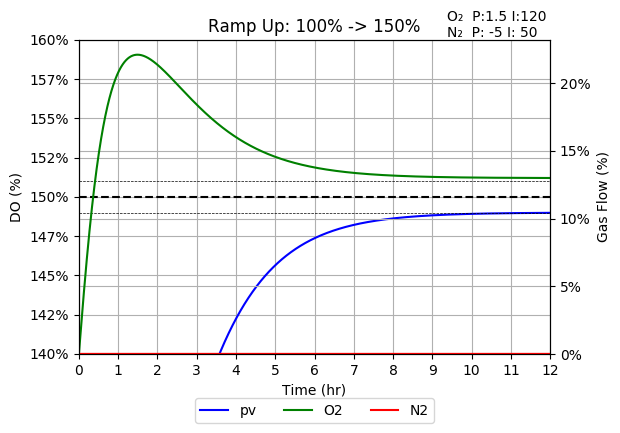

In [46]:
setup2()
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100
ops.end = 12*hours

# Aggressive
# ops.o2_pid.p = 7
# ops.o2_pid.i = 50
# ops.n2_pid.p = -6
# ops.n2_pid.i = 90

# Slower
ops.o2_pid.p = o2p = 1.5
ops.o2_pid.i = o2i = 120
ops.n2_pid.p = n2p = -5
ops.n2_pid.i = n2i = 50

# Balanced?
# ops.o2_pid.p = 1.5
# ops.o2_pid.i = 80
# ops.n2_pid.p = -3
# ops.n2_pid.i = 50

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(140, 160)
a,b = ax2.set_ylim()
ax2.set_ylim(0, b)
ax1.set_title("Ramp Up: 100% -> 150%")
ax1.text(.7, .87, "O\u2082  P:%.1f I:%3d\nN\u2082  P:%3d I:%3d"%(o2p, o2i, n2p, n2i), transform=fig.transFigure)
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\3L ramp up gradual 170720.png")
fig

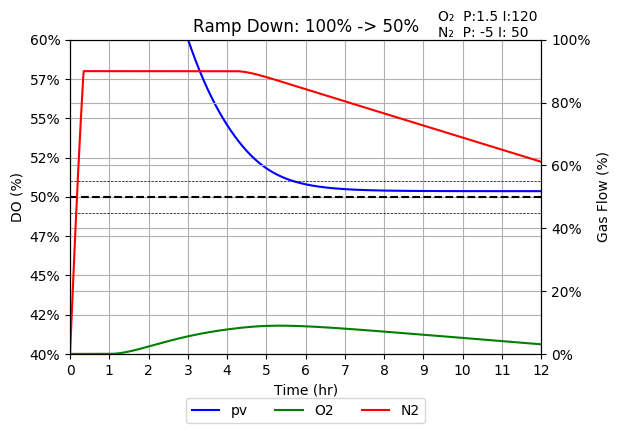

In [47]:
setup2()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

# Aggressive
# ops.o2_pid.p = 7
# ops.o2_pid.i = 50
# ops.n2_pid.p = -6
# ops.n2_pid.i = 90

# Slower
ops.o2_pid.p = o2p = 1.5
ops.o2_pid.i = o2i = 120
ops.n2_pid.p = n2p = -5
ops.n2_pid.i = n2i = 50

# Balanced?
# ops.o2_pid.p = 1.5
# ops.o2_pid.i = 80
# ops.n2_pid.p = -3
# ops.n2_pid.i = 50

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)
ax1.set_title("Ramp Down: 100% -> 50%")
ax1.text(.7, .87, "O\u2082  P:%.1f I:%3d\nN\u2082  P:%3d I:%3d"%(o2p, o2i, n2p, n2i), transform=fig.transFigure)
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\3L ramp down gradual 170720.png")
fig

#### More tuning.....

In [48]:
def rampup(ops, x, y):
    setup2(True)
    data = rampup2(ops)
    finish_rampup(data, x, y)
    
def finish_rampup(data, x, y):
    run4(*data)
    ax1.set_xlim(0, 12)
    ax1.set_ylim(140, 160)
    ax2.set_ylim(0, 1)
    a,b = ax2.set_ylim()
    ax2.set_ylim(0, b)
    ax1.set_title("Ramp Up: Gradual")
    w=fig.canvas._tkcanvas.master
    w.geometry('565x433+%d+%d'%(x,y))
    
def rampdown(ops, x, y):
    setup2(True)
    data = rampdown2(ops)
    finish_rampdown(data, x, y)
    
def finish_rampdown(data, x, y):
    run4(*data)
    ax1.set_xlim(0, 12)
    ax1.set_ylim(40, 60)
    ax2.set_ylim(0, 1)
    ax1.set_title("Ramp Down: Gradual")
    w=fig.canvas._tkcanvas.master
    w.geometry('565x433+%d+%d'%(x,y))
    
def rampup2(ops):
    ops.set_point = 150
    ops.initial_pv = 100
    return test2(ops)
    
def rampdown2(ops):
    ops.set_point = 50
    ops.initial_pv = 100
    return test2(ops)
    
def run4(x, pv, n2, o2, o2a):
    plot2(x, pv, n2, o2, o2a)
    finish2()
    return

def plot3(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    #_p1(ax3, x, pv, "blue", "pv", "DO (%)")
    #_p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()

In [49]:
# Balanced?
for i in range(100): plt.close()
ops.o2_pid.p = 4
ops.o2_pid.i = 70
ops.n2_pid.p = -5
ops.n2_pid.i = 50

rampup(ops, 1932, 0)
rampdown(ops, 2502, 0)

ops.o2_pid.p = 4
ops.o2_pid.i = 60
ops.n2_pid.p = -5
ops.n2_pid.i = 50

rampup(ops, 1932, 500)
rampdown(ops, 2502, 500)

In [50]:
def getscore(n2, o2_2, pv, pv2):
    pv1t = 4*hours
    pv2t = 5*hours
    pv_where1 = pv[pv1t:]
    pv1_passed = np.any(np.abs(149 - pv[:pv1t]) < 1)
    pv_where2 = pv2[pv2t:]
    pv2_passed = np.any(np.abs(51 - pv2[:pv2t]) < 1)
    if not (pv1_passed and pv2_passed):
        return -1
    score = n2.sum()**2/len(n2) + o2_2.sum()**2/len(o2_2) + (np.abs(149-pv_where1).sum()/len(pv_where1) + np.abs(51-pv_where2).sum()/len(pv_where2))*10
    return score


def getscore2(n2, o2_2):
    return n2.sum()**2/len(n2) + o2_2.sum()**2 / len(o2_2)

In [51]:
[plt.close() for _ in range(10)]
ops.o2_pid.p = 1
ops.o2_pid.i = 120
ops.n2_pid.p = -4
ops.n2_pid.i = 105
rampup(ops, 1932, 0)
rampdown(ops, 2502, 0)
x, pv, n2, o2, o2a = rampup2(ops)
x2, pv2, n2_2, o2_2, o2a_2 = rampdown2(ops)
getscore(n2, o2_2, pv, pv2)

-1

In [77]:
[plt.close() for _ in range(10)]
ops.o2_pid.p = 4
ops.n2_pid.p = -20
ops.o2_pid.i = 55
ops.n2_pid.i = 40
ops.end=12*hours
ops.k_mult=1
rampup(ops, 1932, 500)
rampdown(ops, 2502, 500)
#x, pv, n2, o2, o2a = rampup2(ops)
#x2, pv2, n2_2, o2_2, o2a_2 = rampdown2(ops)
#s = getscore(n2, o2_2, pv, pv2)
#s

In [69]:
o2[-10:]

array([ 0.1298609,  0.1298609,  0.1298609,  0.1298609,  0.1298609,
        0.1298609,  0.1298609,  0.1298609,  0.1298609,  0.1298609])

In [61]:
best_3L_data = [
     (1, -1, 40, 40, 525.1),
     (1, -1, 45, 40, 351.6),
     (1, -1, 50, 40, 240.4),
     (1, -1, 55, 40, 172.7),
     (1, -1, 60, 40, 134.6),
     (1, -1, 65, 40, 115.1),
     (1, -1, 70, 40, 106.8),
     (1, -1, 75, 40, 105.4),
     (1, -1, 75, 60, 102.7),
     (1, -1, 80, 60, 94.7),
     (1, -1, 85, 60, 92.7),
     (1, -2, 70, 40, 72.3),
     (1, -2, 75, 40, 63.9),
     (1, -3, 70, 40, 62.5),
     (1, -3, 75, 40, 46.2),
     (1, -3, 80, 40, 43.1),
     (1, -4, 75, 40, 39.3),
     (1, -4, 80, 40, 33.2),
     (1, -5, 80, 40, 28.1),
     (1, -6, 80, 40, 25.1),
     (1, -6, 85, 40, 24.9),
     (1, -6, 85, 45, 24.8),
     (1, -7, 80, 40, 23.2),
     (1, -7, 85, 40, 22.3),
     (1, -7, 85, 45, 22.1),
     (1, -8, 80, 40, 21.9),
     (1, -8, 85, 40, 20.5),
     (1, -8, 85, 45, 20.2),
     (1, -9, 85, 40, 19.1),
     (1, -9, 85, 45, 18.8),
     (1, -10, 85, 40, 18.1),
     (1, -10, 85, 45, 17.8),
     (1, -12, 85, 40, 16.6),
     (1, -12, 85, 45, 16.4),
     (1, -14, 85, 40, 15.6),
     (1, -14, 85, 45, 15.4),
     (1, -16, 85, 40, 15.0),
     (1, -16, 85, 45, 14.7),
     (1, -18, 85, 40, 14.4),
     (1, -18, 85, 45, 14.3),
     (1, -20, 85, 40, 14.0),
     (1, -20, 85, 45, 13.9),
     (2, -5, 60, 40, 13.8),
     (2, -5, 65, 40, 13.7),
     (2, -6, 60, 40, 11.7),
     (2, -6, 65, 40, 10.4),
     (2, -7, 65, 40, 8.3),
     (2, -8, 65, 40, 6.8),
     (2, -9, 65, 40, 5.8),
     (2, -9, 80, 65, 5.5),
     (2, -10, 65, 40, 5.0),
     (2, -10, 80, 65, 4.6),
     (2, -12, 65, 40, 3.9),
     (2, -12, 70, 50, 3.9),
     (2, -12, 75, 55, 3.7),
     (2, -12, 80, 65, 3.3),
     (2, -14, 65, 40, 3.2),
     (2, -14, 70, 50, 3.2),
     (2, -14, 75, 55, 2.8),
     (2, -14, 80, 65, 2.6),
     (2, -16, 75, 55, 2.2),
     (2, -16, 80, 65, 2.1),
     (2, -18, 75, 55, 1.8),
     (2, -20, 75, 55, 1.5),
     (3, -14, 60, 45, 1.2),
     (3, -16, 60, 45, 0.9),
     (3, -18, 60, 45, 0.7),
     (20, -20, 50, 40, 0.6),
     (3, -20, 60, 45, 0.5),
     (4, -20, 55, 40, 0.5)
]

In [62]:
data_cache.clear()

In [64]:
import shutil
shutil.rmtree(".\\do_img_cache", True)
os.makedirs(".\\do_img_cache")
ops.end=12*hours
[plt.close() for i in range(100)]
def text():
    ax1.text(.7, .87, "O\u2082  P:%2d I:%3d\nN\u2082  P:%2d I:%3d\nScore: %.1f"%(o2p, o2i, n2p, n2i, score), transform=fig.transFigure)

def savefig(name, score, i):
    fig.savefig(".\\do_img_cache\\do ramp %s 3L %s %d.png"%(name, score, i))

try:
    data_cache
except NameError:
    data_cache = {}
for i, (o2p, n2p, o2i, n2i, score) in enumerate(best_3L_data[-5:]):
    ops.o2_pid.p = o2p
    ops.n2_pid.p = n2p
    ops.o2_pid.i = o2i
    ops.n2_pid.i = n2i
    key = o2p, n2p, o2i, n2i
    #print("Creating img for score: %s... "%score, end="")
    
    if key in data_cache:
        ud, dd = data_cache[key]
    else:
        ud = rampup2(ops)
        dd = rampdown2(ops)
        data_cache[key] = (ud, dd)
    
    setup2(True)
    finish_rampup(ud, 1932, 500)
    text()
    savefig("up", score, i)
    plt.close()
    
    setup2(True)
    finish_rampdown(dd, 2502, 500)
    text()
    #print("Saving figure... ", end="")
    savefig("down", score, i)
    plt.close()
    #print("Figure saved!")
    
    _, pv, n2, _, _ = ud
    _, pv2, _, o2_2, _ = dd
    print(i, "::", key, score, getscore(n2, o2_2, pv, pv2))   
    

0 :: (3, -16, 60, 45) 0.9 0.874974267223
1 :: (3, -18, 60, 45) 0.7 0.655771686699
2 :: (20, -20, 50, 40) 0.6 0.593321762372
3 :: (3, -20, 60, 45) 0.5 0.512214276364
4 :: (4, -20, 55, 40) 0.5 0.462406161969


### 3L Simulation Window

In [210]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 40
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -5
ops.n2_pid.i = 40
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = .5
ops.mfcs.n2_max = .5
ops.mfcs.air_max = .5

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 5*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 100
ops.set_point = 50
ops.set_point_deadband = 1
ops.k_mult = 1
ops.k = k_3L
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 0.2
ops.reactor_size = 3
ops.reactor_volume = 2.5
ops.time_unit = hours
ops.max_iters = 3 * days

ops.o2_pid.p = 1.5
ops.o2_pid.i = 150

ops.n2_pid.p = -3
ops.n2_pid.i = 50

In [211]:
cfg = SimConfig()
cfg.simops = ops
def run4():
    global root, f
    cfg.simops.o2_pid.p = 1.5
    cfg.simops.o2_pid.i = 150
    cfg.simops.o2_pid.amax = 100
    cfg.simops.o2_pid.deadband = 0
    cfg.simops.o2_pid.beta = 0
    cfg.simops.o2_pid.man_request = 10

    cfg.simops.n2_pid.p = -3
    cfg.simops.n2_pid.i = 50
    cfg.simops.n2_pid.amax = 90
    cfg.simops.n2_pid.deadband = 0
    cfg.simops.n2_pid.beta = 0
    cfg.simops.n2_pid.man_request = 10
    cfg.simops.delay=0*minutes

    cfg.update_interval = 50
    cfg.time_factor = 200

    cfg.simops.initial_pv = 100
    cfg.simops.set_point = 100

    cfg.xwindow_hrs = 10

    root = TkQuitHack()
    root.wm_title("DO Simulation")
    #root.geometry("%dx%d"%(600, 800))
    f = PIDSimFrame(root, cfg)
    f.pack()
    root.mainloop()

In [212]:
run4()

State Value Updated: pv 50.0 
State Value Updated: pv 100.0 
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
Advancing simulation 3600 seconds...
State Value Updated: sp 50.0 
TIMEFACTOR_CHANGED : 0.0
